## DA for image generated by a GAN

In [386]:
#Necessary Imports 
import numpy as np
from numpy.linalg import inv
import pandas as pd
import pickle
from pathlib import Path
import datetime, time

import matplotlib.pyplot as plt

%matplotlib inline 

from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import eofs
from eofs.standard import Eof
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf

In [427]:
#Loading in the selected image 

image_path = 'image_for_DA.npy'

image = np.load(image_path)

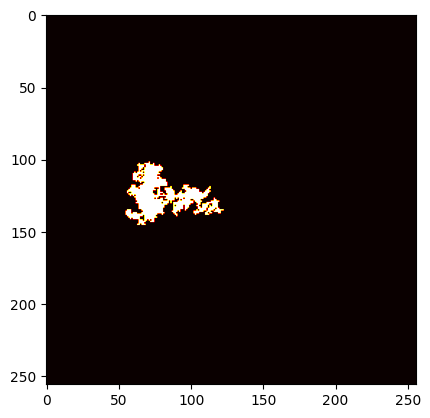

In [430]:
#looking at the image 
plt.imshow(image, cmap='hot')

Now I am going to load in the sensor data so that I can use it to assimilate

In [431]:
#load in sensor data

sensor_data = np.load('Data/Ferguson_fire_obs.npy')

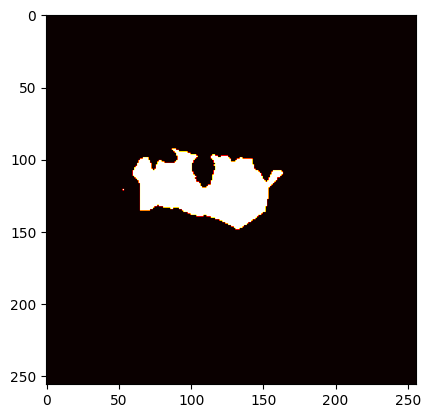

In [432]:
#visualizing one of these 

plt.imshow(sensor_data[0], cmap='hot')

### Seeing the shape of the data

In [433]:
sensor_image = sensor_data[0]
image.shape, sensor_image.shape

((256, 256), (256, 256))

In [434]:
#reshaping the image to be a 1D array

image = image.reshape(1,-1)
sensor_image = sensor_image.reshape(1,-1)

image.shape, sensor_image.shape

((1, 65536), (1, 65536))

In [436]:
#reshape sensor data 
sensor_data = sensor_data.reshape(sensor_data.shape[0], -1)

## Applying PCA to image and sensor data 

In [441]:
#training a PCA on the sensor_data
pca = PCA(n_components=.99) 
pca.fit(sensor_data)

#transform the data
compressed_image_data = pca.transform(image)
compressed_sensors_data = pca.transform(sensor_image)

In [442]:
print(compressed_image_data.shape)
print(compressed_sensors_data.shape)

(1, 4)
(1, 4)


## Applying Data Assimilation

In [443]:
def update_prediction(x, K, H, y):
    res = x + np.dot(K, (y - np.dot(H, x)))
    return res


def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H, np.dot(B, H.transpose())))
    res = np.dot(B, np.dot(H.transpose(), tempInv))
    return res


def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs, y_pred)).mean()

In [444]:
#Establishing covariance matrices
nNodes = 4
I = np.identity(nNodes)
R = np.cov(compressed_sensors_data)  
H = I
B = np.cov(compressed_image_data) 

In [445]:
print("Start Assimilation")
start = time.time()

K = KalmanGain(B, H, R)
print("Kalman Gain:", K.shape)

updated_data_list = []
for i in range(len(compressed_image_data)):
    updated_data = update_prediction(
        compressed_image_data[i], K, H, compressed_sensors_data[i]
    )
    updated_data_list.append(updated_data)

updated_data_array = np.array(updated_data_list)

end = time.time()

print (f"Assimilation took {end - start} seconds")
mse_before_DA = mse(compressed_image_data, compressed_sensors_data)
mse_after_DA = mse(updated_data_array, compressed_sensors_data)

print("MSE before DA:", mse_before_DA)
print("MSE after DA:", mse_after_DA)

Start Assimilation
Kalman Gain: (4, 4)
Assimilation took 0.00037097930908203125 seconds
MSE before DA: 2.2247240270965176
MSE after DA: 0.14043201437780117


In [447]:
# Measure Execution Time
start_time = time.time()

decompressed_model_data = pca.inverse_transform(compressed_image_data)
decompressed_sensor_data = pca.inverse_transform(compressed_sensors_data)
decompressed_updated_data = pca.inverse_transform(updated_data_array)

end_time = time.time()

# Calculate MSE in Physical Space
mse_physical_before_DA = mean_squared_error(decompressed_model_data, sensor_image)
mse_physical_space = mean_squared_error(decompressed_updated_data, sensor_image)

# Print MSE and Execution Time
print("MSE in Physical Space Before DA:", mse_physical_before_DA)
print("MSE in Physical Space After DA:", mse_physical_space)
print("Execution Time for Decompression:", end_time - start_time)


MSE in Physical Space Before DA: 0.00013578637860680513
MSE in Physical Space After DA: 8.57128994002715e-06
Execution Time for Decompression: 0.021757841110229492


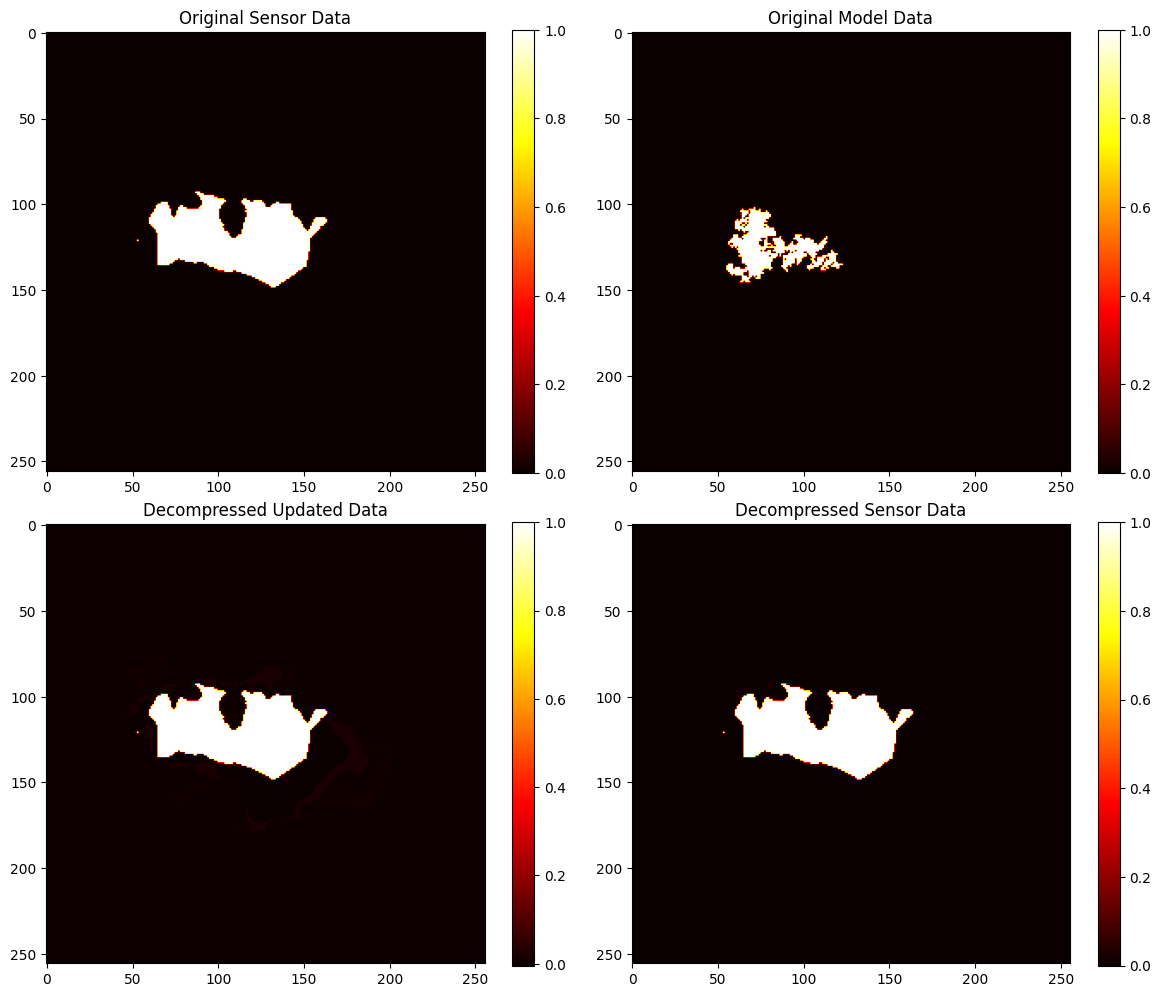

In [448]:
# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot the original sensor data
axes[0, 0].set_title('Original Sensor Data')
im0 = axes[0, 0].imshow(sensor_data[0].reshape(256, 256), cmap='hot')
fig.colorbar(im0, ax=axes[0, 0])

# Plot original model data 
axes[0, 1].set_title('Original Model Data')
im1 = axes[0, 1].imshow(image.reshape(256, 256), cmap='hot')
fig.colorbar(im1, ax=axes[0, 1])

# Plot the decompressed updated data
axes[1, 0].set_title('Decompressed Updated Data')
im2 = axes[1, 0].imshow(decompressed_updated_data[0].reshape(256, 256), cmap='hot')
fig.colorbar(im2, ax=axes[1, 0])

# Plot the decompressed sensor data
axes[1, 1].set_title('Decompressed Sensor Data')
im3 = axes[1, 1].imshow(decompressed_sensor_data[0].reshape(256, 256), cmap='hot')
fig.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()
